In [1]:
import gzip
import os
from chesslm.lichess import LichessPGNEntry

with gzip.open(os.path.expanduser("~/Data/standard_rated_2013-01_filtered.jsonl.gz"), "rb") as f:
    entries: list[LichessPGNEntry] = [
        LichessPGNEntry.model_validate_json(line)
        for line in f.readlines()
    ]

print(len(entries))

37938


(52.68, 0.840081185091465)

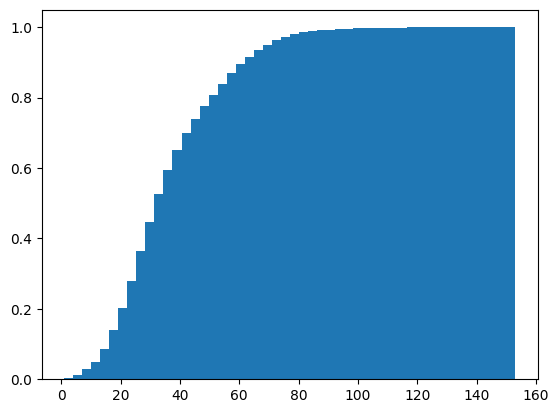

In [2]:
import matplotlib.pyplot as plt
from more_itertools import first

ys, xs, _ = plt.hist(
    [entry.total_moves for entry in entries],
    bins=50,
    cumulative=True,
    density=True,
)

first((float(x), float(y)) for x, y in zip(xs, ys) if x >= 50)

In [3]:
import re
import pygtrie
from functools import cached_property
from typing import Optional

PGN_VOCAB: list[str] = [" "]  # spaces
PGN_VOCAB += [str(i) for i in range(10)]  # 0-9
PGN_VOCAB += [chr(i) for i in range(97, 105)]  # a-h
PGN_VOCAB += ["B", "K", "N", "Q", "R"]  # pieces
PGN_VOCAB += [f"{x}." for x in range(51)]  # start of turn (up to 50 moves)
PGN_VOCAB += ["O-O", "O-O-O", "="]  # castling / promotion
PGN_VOCAB += [" ", "x", "+", "#"]  # capture / check(mate)
PGN_VOCAB += ["0-1", "1-0", "1/2-1/2"]  # outcome

UNK_TOKEN = "<unk>"
UNK_TOKEN_ID = -1
SPECIAL_TOKEN_IDS = {UNK_TOKEN: UNK_TOKEN_ID}

class PGNTokenizer:
    def __init__(self, vocab: Optional[list[str]] = None):
        self.vocab = PGN_VOCAB.copy() if vocab is None else vocab.copy()
        self.word_ids = SPECIAL_TOKEN_IDS.copy()
        self.word_ids |= {word: i for i, word in enumerate(self.vocab)}

    @cached_property
    def re_vocab(self) -> re.Pattern:
        re_special_chars = re.compile(r"([\+\*\?\^\$\\\.\[\]\{\}\(\)\|\/])")
        re_words = sorted(re_special_chars.sub(r"\\\1", word) for word in self.vocab)
        return re.compile("(" + "|".join(re_words[::-1]) + ")")

    def encode(self, text: str) -> list[int]:
        token_ids: list[int] = []
        while text:
            if not (match := self.re_vocab.match(text)):
                raise ValueError(f"could not find next token for '{text}'")
            token_ids.append(self.word_ids[match.group()])
            text = text[match.end() :]
        return token_ids

    def finditer_encode(self, text: str) -> list[int]:
        token_ids: list[int] = []
        end_ = 0
        for match in self.re_vocab.finditer(text):
            start, end = match.span()
            if start != end_:
                raise ValueError(f"could not find next token for '{text[end_ : start]}'")
            end_ = end
            token_ids.append(self.word_ids[match.group()])
        return token_ids

    @cached_property
    def re_findall(self) -> re.Pattern:
        re_special_chars = re.compile(r"([\+\*\?\^\$\\\.\[\]\{\}\(\)\|\/])")
        re_words = sorted(re_special_chars.sub(r"\\\1", word) for word in self.vocab)
        return re.compile("(" + "|".join(re_words[::-1]) + r"|[^ ]+" ")")

    def findall_encode(self, text: str) -> list[int]:
        return [
            self.word_ids.get(match, UNK_TOKEN_ID)
            for match in self.re_findall.findall(text)
        ]

    @cached_property
    def trie(self) -> pygtrie.CharTrie:
        return pygtrie.CharTrie(self.word_ids)

    def trie_encode(self, text: str) -> list[int]:
        # A "ground truth" longest-match encoder. Very slow, only use for debugging.
        token_ids: list[int] = []
        while text:
            word, i = self.trie.longest_prefix(text)
            if not word:
                raise ValueError(f"could not find next token for '{text}'")
            token_ids.append(i)
            text = text[len(word) :]
        return token_ids

    def decode(self, ids: list[int]) -> str:
        return "".join(self.vocab[i] for i in ids)

tokenizer = PGNTokenizer()

In [4]:
import random

samples = random.sample(entries, 20000)
sample = samples[0]
seq = sample.plain_sequence

print(len(ids := tokenizer.trie_encode(seq)), tokenizer.decode(ids) == seq)
print(len(ids := tokenizer.encode(seq)), tokenizer.decode(ids) == seq)
print(len(ids := tokenizer.finditer_encode(seq)), tokenizer.decode(ids) == seq)
print(len(ids := tokenizer.findall_encode(seq)), tokenizer.decode(ids) == seq)

603 True
603 True
603 True
603 True


In [5]:
from tqdm import tqdm

for sample in tqdm(samples):
    tokenizer.findall_encode(sample.plain_sequence)

100%|██████████| 20000/20000 [00:03<00:00, 5152.53it/s]


In [6]:
def random_sequence() -> str:
    return random.sample(entries, 1)[0].plain_sequence

# %timeit -n100 tokenizer.trie_encode(random_sequence())
%timeit -n100 tokenizer.encode(random_sequence())
%timeit -n100 tokenizer.finditer_encode(random_sequence())
%timeit -n100 tokenizer.findall_encode(random_sequence())

387 μs ± 25 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
347 μs ± 31.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
212 μs ± 25.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
